# Catcher Center of Mass Intended Target Estimator -- Gloce Position Agnostic
---
If you have any questions, please contact the authors of the repository.

### Pre-work

Let's make sure that we have access to GPU. We can use nvidia-smi command to do that. In case of any problems navigate to Edit -> Notebook settings -> Hardware accelerator, set it to GPU, and then click Save.

In [ ]:
!nvidia-smi
!lspci | grep -i nvidia

In [ ]:
#!git clone https://github.com/dylandru/BaseballCV.git
%cd BaseballCV
#!pip install -r requirements.txt

## Import required libraries

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import torch
import os
import moviepy.editor as mpy
from scripts.load_tools import LoadTools
from scipy import stats
# Initialize LoadTools class
load_tools = LoadTools()
load_tools.load_dataset("baseball_rubber_home_glove")  # can be any dataset within files


In [ ]:
SOURCE_IMAGE_PATH = (
    "baseball_rubber_home_glove/baseball_rubber_home_glove/test/images/0009100.jpg"
)
print("Source Image Updated.")


In [ ]:
model_weights_phc = load_tools.load_model("phc_detector")
model_phc = YOLO(model_weights_phc)
results_phc = model_phc.predict(source=SOURCE_IMAGE_PATH, save=True)

In [ ]:
from IPython.display import Image
import os
files = os.listdir(results_phc[0].save_dir)
##show first picture
Image(filename=f"{results_phc[0].save_dir}/{files[0]}", width=600)

In [ ]:
### run annotation for plate, rubber, ball

model_weights_plate = load_tools.load_model(model_alias="glove_tracking")
model_plate = YOLO(model_weights_plate)
results_plate = model_plate.predict(source=SOURCE_IMAGE_PATH, save=True,conf=.1)

In [ ]:
from IPython.display import Image
import os

files = os.listdir(results_plate[0].save_dir)
##show first picture
Image(filename=f"{results_plate[0].save_dir}/{files[0]}", width=600)

In [ ]:
results_plate

In [265]:
catcher = (
    results_phc[0]
    .boxes[torch.where(results_phc[0].boxes.cls == 2.0)[0].tolist()[0]]
)
plate = results_plate[0].boxes[
    torch.where(results_plate[0].boxes.cls == 1.0)[0].tolist()[0]
]
rubber = results_plate[0].boxes[
    torch.where(results_plate[0].boxes.cls == 3.0)[0].tolist()[0]
]
glove = results_plate[0].boxes[
    torch.where(results_plate[0].boxes.cls == 0.0)[0].tolist()[0]
]

In [ ]:
## some helper functions to make later code cleaner
## simple slope / distance / endpoint functions

def slope_of_line(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    if x1 == x2:
        return None  
    slope = (y2 - y1) / (x2 - x1)

    return slope

def find_endpoint(start_point, slope, length, visual=False):
    x1, y1 = start_point

    angle = math.atan(slope)

    delta_x = math.cos(angle) * length
    delta_y = math.sin(angle) * length

    x2 = x1 + delta_x
    y2 = y1 + delta_y
    if visual:
        return (int(x2), int(y2))
    else:
        return (x2, y2)




def distance_between_points(point1, point2):
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the Euclidean distance
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    return distance

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread(SOURCE_IMAGE_PATH)
shape = image.shape
cx1, cy1, cx2, cy2 = catcher.xyxy[0]
cv2.rectangle(image, (int(cx1), int(cy1)), (int(cx2), int(cy2)), (0, 255, 0), 2)
px1, py1, px2, py2 = plate.xyxy[0]
cv2.rectangle(image, (int(px1), int(py1)), (int(px2), int(py2)), (0, 0, 255), 2)
rx1, ry1, rx2, ry2 = rubber.xyxy[0]
depth =abs(int(rx1) - int(rx2)) / 2 * 5 / 6

cv2.rectangle(image, (int(rx1), int(ry1)), (int(rx2), int(ry2)), (0, 0, 255), 2)  # ~~59.09 straight line front Center HP to Front Center Rubber.. In theory... 
## Air Line
cv2.line(
    image,
    (int(rx1), int(np.mean([int(ry1), int(ry2)]))),
    (int(px1), int(np.mean([int(py1), int(py2)]))),
    (255, 0, 0),
    2,
)  # ~~59.09 straight line front Center HP to Front Center Rubber.. In theory... Left Line
cv2.line(
    image,
    (int(rx2), int(np.mean([int(ry1), int(ry2)]))),
    (int(px2), int(np.mean([int(py1), int(py2)]))),
    (255, 0, 0),
    2,
)  # ~~59.09 straight line front Center HP to Front Center Rubber.. In theory... Right Line
cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    (int(np.mean([int(rx1), int(rx2)])), int(np.mean([int(ry1), int(ry2)]))),
    (255, 0, 0),
    2,
)  # center plate to center rubber 
### Ground Line
cv2.line(
    image,
    (int(rx1), int(np.mean([int(ry1), int(ry2)])) + int(depth)),
    (int(px1), int(np.mean([int(py1), int(py2)]))),
    (125, 0, 0),
    1,
)  # ~~59.09 straight line front Center HP to Front Center Rubber.. In theory... Left Line
cv2.line(
    image,
    (int(rx2), int(np.mean([int(ry1), int(ry2)])) + int(depth)),
    (int(px2), int(np.mean([int(py1), int(py2)]))),
    (125, 0, 0),
    1,
)  # ~~59.09 straight line front Center HP to Front Center Rubber.. In theory... Right Line
cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    (
        int(np.mean([int(rx1), int(rx2)])),
        int(np.mean([int(ry1), int(ry2)])) + int(depth),
    ),
    (125, 0, 0),
    1,
)  # center plate to center rubber
### Vertical Plane
cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), shape[0]),
    (int(np.mean([int(px1), int(px2)])), 0),
    (255, 0, 0),
    2,
)  # center plate
cv2.line(
    image,
    (int(np.mean([int(rx1), int(rx2)])), shape[0] ),
    (int(np.mean([int(rx1), int(rx2)])), 0 ),
    (255, 0, 0),
    2,
)  # center rubber
### View Angle 




image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [267]:
def slope_of_line(point1, point2):
    x1, y1 = point1
    x2, y2 = point2

    # Check for vertical line (undefined slope)
    if x1 == x2:
        return None  # Slope is undefined for vertical lines

    # Calculate slope
    slope = (y2 - y1) / (x2 - x1)

    return slope
import math


def find_endpoint(start_point, slope, length,visual=False):
    x1, y1 = start_point

    # Calculate the angle from the slope
    angle = math.atan(slope)

    # Calculate change in x and y using trigonometry
    delta_x = math.cos(angle) * length
    delta_y = math.sin(angle) * length

    # Determine the end point
    x2 = x1 + delta_x
    y2 = y1 + delta_y
    if visual:
        return (int(x2),int(y2))
    else:
        return (x2,y2)


import math


def distance_between_points(point1, point2):
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the Euclidean distance
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    return distance



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread(SOURCE_IMAGE_PATH)
shape = image.shape
cx1, cy1, cx2, cy2 = catcher.xyxy[0]
px1, py1, px2, py2 = plate.xyxy[0]
rx1, ry1, rx2, ry2 = rubber.xyxy[0]
gx1, gy1, gx2, gy2 = glove.xyxy[0]


cv2.rectangle(
    image, (int(rx1), int(ry1)), (int(rx2), int(ry2)), (0, 0, 255), 2
)  # ~~59.09 straight line front Center HP to Front Center Rubber.. In theory...
## Air Line
cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    (int(np.mean([int(rx1), int(rx2)])), int(np.mean([int(ry1), int(ry2)]))),
    (255, 0, 0),
    2,
)  # center plate to center rubber
# Ground Line
cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    (
        int(np.mean([int(rx1), int(rx2)])),
        int(np.mean([int(ry1), int(ry2)])) + int(depth),
    ),
    (125, 0, 0),
    1,
)  # center plate to center rubber
### Vertical Plane
cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), shape[0]),
    (int(np.mean([int(px1), int(px2)])), int(py2)),
    (255, 0, 0),
    2,
)  # center plate
cv2.line(
    image,
    (int(np.mean([int(rx1), int(rx2)])), shape[0]),
    (int(np.mean([int(rx1), int(rx2)])), int(ry2)),
    (255, 0, 0),
    2,
)  # center rubber


## assume catcher is 6 ft back from corner
# Step 1, get angle of ground line
ground_line_slope = slope_of_line(
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    (
        int(np.mean([int(rx1), int(rx2)])),
        int(np.mean([int(ry1), int(ry2)])) + int(depth),
    ),
)

catcher_beyond_pixlewidth = distance_between_points(
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    (
        int(np.mean([int(rx1), int(rx2)])),
        int(np.mean([int(ry1), int(ry2)])) + int(depth),
    ),
) / 59.5 * 6

endpoint_center = find_endpoint(
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    ground_line_slope,
    catcher_beyond_pixlewidth,
    visual=True,
)

cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
    endpoint_center,
    (255, 235, 0),
    2,
)  # center plate extend catcher

endpoint_firstbaseside = find_endpoint(
    (int(px1), int(np.mean([int(py1), int(py2)]))),
    ground_line_slope,
    catcher_beyond_pixlewidth,
    visual=True,
)
cv2.line(
    image,
    ((int(px1)), int(np.mean([int(py1), int(py2)]))),
    endpoint_firstbaseside,
    (255, 235, 0),
    2,
)  # left corner plate extend catcher
cv2.line(
    image,
    endpoint_firstbaseside,
    (endpoint_firstbaseside[0],0),
    (255, 235, 0),
    2,
)  # left corner plate extend catcher

endpoint_thirdbaseside = find_endpoint(
    (int(px2), int(np.mean([int(py1), int(py2)]))),
    ground_line_slope,
    catcher_beyond_pixlewidth,
    visual=True,
)
cv2.line(
    image,
    ((int(px2)), int(np.mean([int(py1), int(py2)]))),
    endpoint_thirdbaseside,
    (255, 235, 0),
    2,
)  # right corner plate extend catcher
cv2.line(
    image,
    endpoint_thirdbaseside,
    (endpoint_thirdbaseside[0], 0),
    (255, 235, 0),
    2,
)  # right corner plate extend catcher

#### Harmonic Mean of Top and Glove for Horizontal Target Location
catcher_top = min(int(cy1),int(cy2))
glove_center = np.mean([int(gy1), int(gy2)])
harmonic_mean_vert = np.mean([int(cy1), int(cy2), glove_center,])

glove_center_horz = np.mean([int(gx1), int(gx2)])
harmonic_mean_horz = np.mean(
    [
        int(cx1),
        int(cx2),
        glove_center_horz,
    ]
)
x_translate = int(px1) - endpoint_firstbaseside[0]
cv2.line(
    image,
    (int(endpoint_thirdbaseside[0]), int(harmonic_mean_vert)),
    (int(endpoint_firstbaseside[0]), int(harmonic_mean_vert)),
    (0, 215, 255),
    2,
)  # vertical target

cv2.line(
    image,
    (
        int(harmonic_mean_horz),
        int(cy1),
    ),
    (int(harmonic_mean_horz), int(cy2)),
    (0, 215, 255),
    2,
)  # horz target
cv2.putText(
    image,
    "Est Intended Target Zone",
    org=(
        int(harmonic_mean_horz),
        int(cy1),
    ),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=1,
    color=(0, 215, 255),  # White color
    thickness=2,
    lineType=cv2.LINE_AA,
)


image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

In [ ]:
harmonic_mean

In [ ]:
###
# assume catcher at 6 ft depth from HP


endpoint

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread(SOURCE_IMAGE_PATH)
shape = image.shape
cx1, cy1, cx2, cy2 = catcher.xyxy[0]
cv2.rectangle(image, (int(cx1), int(cy1)), (int(cx2), int(cy2)), (0, 255, 0), 2)
px1, py1, px2, py2 = plate.xyxy[0]
cv2.rectangle(image, (int(px1), int(py1)), (int(px2), int(py2)), (0, 0, 255), 2)
rx1, ry1, rx2, ry2 = rubber.xyxy[0]
depth = abs(int(rx1) - int(rx2)) / 2 * 5 / 6

cv2.rectangle(
    image, (int(rx1), int(ry1)), (int(rx2), int(ry2)), (0, 0, 255), 2
)  # ~~59.09 straight line front Center HP to Front Center Rubber.. In theory...
## Air Line
### Vertical Plane
cv2.line(
    image,
    (int(np.mean([int(px1), int(px2)])), shape[0]),
    (int(np.mean([int(px1), int(px2)])), 0),
    (255, 0, 0),
    2,
)  # center plate
cv2.line(
    image,
    (int(np.mean([int(rx1), int(rx2)])), shape[0]),
    (int(np.mean([int(rx1), int(rx2)])), 0),
    (255, 0, 0),
    2,
)  # center rubber
### View Angle


image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

In [167]:
import math
def dis(p1, p2):
    """
    Calculate the Euclidean distance between two points p1 and p2.

    Parameters:
    p1 (tuple): Coordinates of the first point (x1, y1)
    p2 (tuple): Coordinates of the second point (x2, y2)

    Returns:
    float: Euclidean distance between the two points
    """
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

In [ ]:
## Assuming arc distance at can be approximated by a straight line.
# from center points what are the pixle distances
r_h = dis(
    (int(np.mean([int(rx1), int(rx2)])), int(min([int(ry1), int(ry2)]))),
    (int(np.mean([int(px1), int(px2)])), int(max([int(py1), int(py2)]))),
)

r_side= dis(
    (int(np.mean([int(rx1), int(rx2)])), int(min([int(ry1), int(ry2)]))),
    (int(np.mean([int(px1), int(px2)])), int(min([int(ry1), int(ry2)]))),
)
side_h = dis(
    (int(np.mean([int(px1), int(px2)])), int(min([int(py1), int(py2)]))),
    (int(np.mean([int(px1), int(px2)])), int(min([int(ry1), int(ry2)]))),
)
print(r_h, r_side, side_h)


math.acos(r_side/r_h) * 180 / math.pi

In [196]:
import cv2
import numpy as np

# 3D world coordinates of the points
points_3D = np.array(
    [
        [0, 1.41, 0],  # Center Front of Plate in 3D Coordinates (TM Coords)
        [0, 60.5, 0.833],  # Center Front Rubber
        [0, 60.5, 0],  # Estimated Ground Point
    ],
    dtype=np.float32,
)
# 2D image coordinates of the points
points_2D = np.array(
    [
        [
            int(np.mean([int(px1), int(px2)])),
            int(max([int(py1), int(py2)])),
        ],  # Corresponding plate
        [
            int(np.mean([int(rx1), int(rx2)])),
            int(min([int(ry1), int(ry2)])),
        ],  # Corresponding rubber air
        [
            int(np.mean([int(rx1), int(rx2)])),
            int(np.mean([int(ry1), int(ry2)])) + int(depth),
        ],  # Corresponding rubber ground
    ],
    dtype=np.float32,
)

# Camera intrinsic matrix (assume you know this from calibration)
focal_length = 100000  # Approximate focal length (in pixels)
image_width = int(image.shape[1])  # Width of the image
image_height = int(image.shape[0])  # Height of the image

# Assume principal point is the center of the image
c_x = image_width / 2
c_y = image_height / 2

camera_matrix = np.array(
    [[focal_length, 0, c_x], [0, focal_length, c_y], [0, 0, 1]], dtype=np.float32
)
dist_coeffs = np.zeros((4, 1))  # or provide distortion coefficients


In [ ]:
# You can now use this matrix for PnP:
results = cv2.solveP3P(
    points_3D, points_2D, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_AP3P
)
results

In [ ]:
### select focus area for image based on CATCHER BOX
x1, y1, x2, y2 = catcher.xyxy[0]
image = cv2.imread(SOURCE_IMAGE_PATH)

cropped_image = image[int(y1):int(y2), int(x1):int(x2)]  # Note the order of dimensions (y, x)
cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

# Display the cropped image
plt.imshow(cropped_image_rgb)
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

In [ ]:
import cv2
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

import time

mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils
results = pose.process(cropped_image_rgb)

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task



base_options = python.BaseOptions(model_asset_path="pose_landmarker.task")
options = vision.PoseLandmarkerOptions(
    base_options=base_options, output_segmentation_masks=True,min_pose_detection_confidence = .1, min_tracking_confidence = .1,
      min_pose_presence_confidence = .1,

)
detector = vision.PoseLandmarker.create_from_options(options)

In [ ]:
mp_image = mp.Image(image_format = mp.ImageFormat.SRGB, data = cropped_image_rgb)

detection_result = detector.detect(mp_image)
detection_result

In [127]:
# @markdown To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend(
            [
                landmark_pb2.NormalizedLandmark(
                    x=landmark.x, y=landmark.y, z=landmark.z
                )
                for landmark in pose_landmarks
            ]
        )
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style(),
        )
    return annotated_image

In [ ]:
annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)
plt.imshow(annotated_image)
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

In [ ]:
!ls
%cd BaseballCV/


In [2]:
#### Try with Video
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import torch
import moviepy.editor as mpy
from scripts.load_tools import LoadTools

# Initialize LoadTools class
load_tools = LoadTools()

In [48]:
def max_conf_baseball(results):
    max_conf_frame = 0
    max_conf = 0
    for i in range(0, len(results)):
        box = results[i].boxes
        for k in range(0, len(box.cls)):
            cls = box.cls[k]
            if int(cls) == 2:
                max_conf_frame = max_conf_frame if max_conf >= float(box.conf[k]) else i
                max_conf = (
                    max_conf if max_conf >= float(box.conf[k]) else float(box.conf[k])
                )
    return max_conf_frame

In [ ]:
SOURCE_VIDEO_PATH = "assets/example_broadcast_video.mp4"

# Load the model
model = YOLO(load_tools.load_model("glove_tracking"))
model_2 = YOLO(load_tools.load_model("phc_detector"))

results = model.predict(source=SOURCE_VIDEO_PATH, save=True)
files = os.listdir(results[0].save_dir)

results_2 = model_2.predict(source=f"{results[0].save_dir}/{files[0]}", save=True)
max_conf_frame = max_conf_baseball(results)




In [ ]:
import cv2

files = os.listdir(results[0].save_dir)
# Load the video
video_path = f"{results[0].save_dir}/{files[0]}"
cap = cv2.VideoCapture(video_path)

# Check if the video is opened successfully
if not cap.isOpened():
    print("Error opening video file")

# Set the frame number you want to extract
frame_number = max_conf_frame  # Change this to any frame number you want to extract

# Set the current frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = cap.read()

# Display the frame
plt.imshow(frame)
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

In [ ]:
import moviepy.editor
import os
files = os.listdir(results[0].save_dir)
##show first picture
# Load the video file
video = moviepy.editor.VideoFileClip(filename=f"{results[0].save_dir}/{files[0]}")
# Resize the video to a new resolution, e.g., (width, height)
resized_video = video.resize((640, 360))  # Example: resizing to 640x360
moviepy.editor.ipython_display(resized_video)

In [ ]:
import moviepy.editor
import os

files = os.listdir(results_2[0].save_dir)
##show first picture
# Load the video file
video = moviepy.editor.VideoFileClip(filename=f"{results_2[0].save_dir}/{files[0]}")
# Resize the video to a new resolution, e.g., (width, height)
resized_video = video.resize((640, 360))  # Example: resizing to 640x360
moviepy.editor.ipython_display(resized_video)

### Try to Get Pitcher Release Frame


In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task


#### Create Detector, Set Options
base_options = python.BaseOptions(model_asset_path="pose_landmarker.task")
options = vision.PoseLandmarkerOptions(
    base_options=base_options, output_segmentation_masks=True,min_pose_detection_confidence = .5, min_tracking_confidence = .5,
      min_pose_presence_confidence = .5,

)
detector = vision.PoseLandmarker.create_from_options(options)

In [ ]:
#### Get pitcher frames from video, crop video so only pitcher is in frame
SOURCE_VIDEO_PATH = "assets/example_broadcast_video.mp4"
model_phc = YOLO(load_tools.load_model("phc_detector"))
results_phc = model_phc.predict(source=SOURCE_VIDEO_PATH, save=False)
model_ball = YOLO(load_tools.load_model("ball_tracking"))

In [41]:
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend(
            [
                landmark_pb2.NormalizedLandmark(
                    x=landmark.x, y=landmark.y, z=landmark.z
                )
                for landmark in pose_landmarks
            ]
        )
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style(),
        )
    return annotated_image

In [9]:
pitcher_frames = []
for result in results_phc:
    index = torch.where(result.boxes.cls == 1)[0].tolist()
    if index == []:
        pitcher_frames.append([])
    else:
        pitcher = result.boxes[index[0]]
        pitcher_frames.append(pitcher.xyxy[0])

        

In [ ]:
## crop each frame and run mediapipe & ball tracker
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
cropped_frames = {}
detection_results = {}
results_ball_dict = {}
images = {}
for i in range(0, len(pitcher_frames)):
    if pitcher_frames[i] == []:
        continue
    else:
        x1, y1, x2, y2 = pitcher_frames[i]
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        cropped_image = frame[
            int(y1) : int(y2), int(x1) : int(x2)
        ]  # Note the order of dimensions (y, x)
        cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        mp_image_eval = mp.Image(image_format=mp.ImageFormat.SRGB, data=cropped_image_rgb)
        detection_result = detector.detect(mp_image_eval)
        
        cropped_frames[i] = cropped_image_rgb
        detection_results[i] = detection_result

        if len(detection_result.pose_landmarks) == 0:
            continue

        ## use mediapipe to determine hand
        lw = detection_result.pose_landmarks[0][15]
        rw = detection_result.pose_landmarks[0][16]

        if 0.9 <= lw.visibility / rw.visibility <= 1.1:
            sw = lw if lw.z < rw.z else rw
        else:
            sw = lw if lw.visibility >  rw.visibility else rw

        x_norm = sw.x
        y_norm = sw.y
        margin = 0.1

        height, width, _ = cropped_image_rgb.shape
        x_center = int(x_norm * width)
        y_center = int(y_norm * height)

        # Calculate the pixel margin
        x_margin = int(margin * width)
        y_margin = int(margin * height)

        # Define the cropping boundaries
        x_min = max(0, x_center - x_margin)
        x_max = min(width, x_center + x_margin)
        y_min = max(0, y_center - y_margin)
        y_max = min(height, y_center + y_margin)
        cropped_image_ball = cropped_image_rgb[y_min:y_max, x_min:x_max]

        ## I GOT THE BALL, I GOT THE BALL, use the mediapip alg to find the release hand

        results_ball = model_ball.predict(
            source=cropped_image_ball, save=False, conf=0.1
        )
        results_ball_dict[i] = results_ball
        index_ball = torch.where(results_ball[0].boxes.cls == 16.0)[0].tolist()
        print(i,index_ball)
        if index_ball != []:

            ball = results_ball[0].boxes[index_ball[0]]
            bx1, by1, bx2, by2 = ball.xyxy[0]

            rect_image = cv2.rectangle(
                cropped_image_ball,
                (int(bx1), int(by1)),
                (int(bx2), int(by2)),
                (0, 0, 255),
                2,
            )

            images[i] = rect_image

In [ ]:
x = []
for i in results_ball_dict.keys():
    if torch.where(results_ball_dict[i][0].boxes.cls == 16.0)[0].tolist() != []:
        x.append(i)
x

In [ ]:
for i in images.keys():
    plt.imshow(images[i])
    plt.title(i)
    plt.axis("off")  # Turn off axis numbers and ticks
    plt.show()

In [ ]:
lw = detection_results[152].pose_landmarks[0][15]
rw = detection_results[152].pose_landmarks[0][16]

if 0.8 <= lw.visibility / rw.visibility <= 1.2:
    sw = lw if lw.z < rw.z else rw
else:
    sw = lw if lw.visibility >  rw.visibility else rw
sw
images[i]
## get cropped image based on hand
image = cropped_image
x_norm = sw.x
y_norm = sw.y
margin = 0.1

height, width, _ = images[i].shape
x_center = int(x_norm * width)
y_center = int(y_norm * height)

# Calculate the pixel margin
x_margin = int(margin * width)
y_margin = int(margin * height)

# Define the cropping boundaries
x_min = max(0, x_center - x_margin)
x_max = min(width, x_center + x_margin)
y_min = max(0, y_center - y_margin)
y_max = min(height, y_center + y_margin)
cropped_image = images[i][y_min:y_max, x_min:x_max]
plt.imshow(cropped_image)
plt.axis('off')
plt.show()

In [ ]:
cropped_image_rgb.shape

In [2]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import torch
import os
import moviepy.editor as mpy
from scripts.load_tools import LoadTools
from scipy import stats

# Initialize LoadTools class
load_tools = LoadTools()
SOURCE_VIDEO_PATH = "assets/example_broadcast_video.mp4"
model_phc = YOLO(load_tools.load_model("phc_detector"))
results_phc = model_phc.predict(source=SOURCE_VIDEO_PATH, save=False)
model_ball = YOLO(load_tools.load_model("ball_tracking"))

ModuleNotFoundError: No module named 'scripts.load_tools'

In [70]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task


#### Create Detector, Set Options
base_options = python.BaseOptions(model_asset_path="pose_landmarker.task")
options = vision.PoseLandmarkerOptions(
    base_options=base_options, output_segmentation_masks=True,min_pose_detection_confidence = .6, min_tracking_confidence = .6,
      min_pose_presence_confidence = .6,
)
mp_pose = mp.solutions.pose
detector = vision.PoseLandmarker.create_from_options(options)
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend(
            [
                landmark_pb2.NormalizedLandmark(
                    x=landmark.x, y=landmark.y, z=landmark.z
                )
                for landmark in pose_landmarks
            ]
        )
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style(),
        )
    return annotated_image



I0000 00:00:1729454133.623474    7353 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1729454133.667345    9382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729454133.737849    9382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [71]:
pitcher_frames = []
xyz_dict = {key: {"x": [], "y": [], "z": []} for key in ["lw", "rw", "ls", "rs"]}
xyz_dict["frame"] = []
images = {}
i= 0
for result in results_phc:
    index = torch.where(result.boxes.cls == 1)[0].tolist()
    if index == []:
        i=i+1
        continue        
    else:
        pitcher = result.boxes[index[0]]
        x1, y1, x2, y2 = pitcher.xyxy[0]
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        cropped_image = frame[
            int(y1) : int(y2), int(x1) : int(x2)
        ]  # Note the order of dimensions (y, x)
        cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        mp_image_eval = mp.Image(
            image_format=mp.ImageFormat.SRGB, data=cropped_image_rgb
        )
        detection_result = detector.detect(mp_image_eval)
        if len(detection_result.pose_landmarks) == 0:
            continue

        else:
            xyz_dict["lw"]["z"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].z
            )
            xyz_dict["rw"]["z"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].z
            )
            xyz_dict["ls"]["z"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].z
            )
            xyz_dict["rs"]["z"].append(
                detection_result.pose_landmarks[0][
                    mp_pose.PoseLandmark.RIGHT_SHOULDER
                ].z
            )
            xyz_dict["lw"]["x"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].x
            )
            xyz_dict["rw"]["x"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].x
            )
            xyz_dict["ls"]["x"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].x
            )
            xyz_dict["rs"]["x"].append(
                detection_result.pose_landmarks[0][
                    mp_pose.PoseLandmark.RIGHT_SHOULDER
                ].x
            )
            xyz_dict["lw"]["y"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].y
            )
            xyz_dict["rw"]["y"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].y
            )
            xyz_dict["ls"]["y"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].y
            )
            xyz_dict["rs"]["y"].append(
                detection_result.pose_landmarks[0][
                    mp_pose.PoseLandmark.RIGHT_SHOULDER
                ].y
            )
            xyz_dict["frame"].append(i)
        images[i] = draw_landmarks_on_image(cropped_image_rgb, detection_result)

In [72]:
for i in range(0, len(pitcher_frames)):
    if pitcher_frames[i] == []:
        continue
    else:
        x1, y1, x2, y2 = pitcher_frames[i]
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        cropped_image = frame[
            int(y1) : int(y2), int(x1) : int(x2)
        ]  # Note the order of dimensions (y, x)
        cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        mp_image_eval = mp.Image(
            image_format=mp.ImageFormat.SRGB, data=cropped_image_rgb
        )
        detection_result = detector.detect(mp_image_eval)
        if len(detection_result.pose_landmarks) == 0:
            continue

        else:
            xyz_dict["lw"]['z'].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].z
            )
            xyz_dict["rw"]["z"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].z
            )
            xyz_dict["ls"]["z"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].z
            )
            xyz_dict["rs"]["z"].append(
                detection_result.pose_landmarks[0][
                    mp_pose.PoseLandmark.RIGHT_SHOULDER
                ].z
            )
            xyz_dict["lw"]["x"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].x
            )
            xyz_dict["rw"]["x"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].x
            )
            xyz_dict["ls"]["x"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].x
            )
            xyz_dict["rs"]["x"].append(
                detection_result.pose_landmarks[0][
                    mp_pose.PoseLandmark.RIGHT_SHOULDER
                ].x
            )
            xyz_dict["lw"]["y"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].y
            )
            xyz_dict["rw"]["y"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].y
            )
            xyz_dict["ls"]["y"].append(
                detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].y
            )
            xyz_dict["rs"]["y"].append(
                detection_result.pose_landmarks[0][
                    mp_pose.PoseLandmark.RIGHT_SHOULDER
                ].y
            )
            xyz_dict["frame"].append(i)
        images[i] = draw_landmarks_on_image(cropped_image_rgb, detection_result)

In [73]:
print(min(xyz_dict["lw"]['z']), max(xyz_dict["lw"]['z']))
print(min(xyz_dict["rw"]['z']), max(xyz_dict["rw"]['z']))

# get estimated minimum Z around throwing hand
max_index = xyz_dict["rw"]['z'].index(min(xyz_dict["rw"]['z']))

## get points around min z
local_x_lw = xyz_dict["lw"]['x'][(max_index - 10) : (max_index + 10)]
local_x_rw = xyz_dict["rw"]["x"][(max_index - 10) : (max_index + 10)]
local_frame = xyz_dict["frame"][(max_index - 10) : (max_index + 10)]

#get the max distance between wrists in x plane within this region
max_distance = [abs(l - r) for l, r in zip(local_x_lw, local_x_rw)]
max_index = max_distance.index(max(max_distance))
local_frame[max_index]

-0.9310809373855591 1.8604016304016113
-2.1646556854248047 1.492470383644104


178

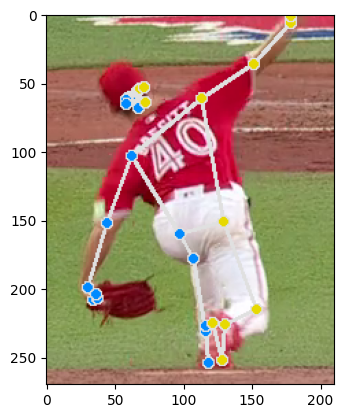

In [74]:
plt.imshow(images[178])
plt.show()

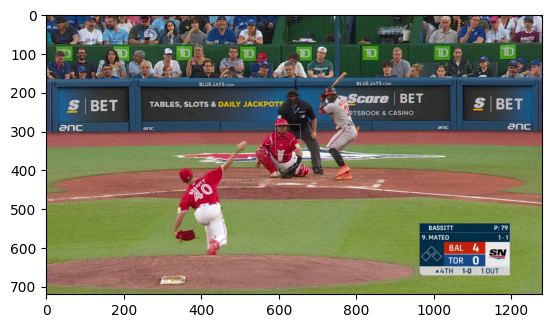

In [75]:
cap.set(cv2.CAP_PROP_POS_FRAMES, 178)
ret, frame = cap.read()
image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


In [1]:
model_weights_phc = load_tools.load_model("phc_detector")
model_phc = YOLO(model_weights_phc)
results_phc = model_phc.predict(source=frame)
catcher = results_phc[0].boxes[
    torch.where(results_phc[0].boxes.cls == 2.0)[0].tolist()[0]
]
### select focus area for image based on CATCHER BOX
x1, y1, x2, y2 = catcher.xyxy[0]

cropped_image = frame[
    int(y1) : int(y2), int(x1) : int(x2)
]  # Note the order of dimensions (y, x)
cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

# Display the cropped image
plt.imshow(cropped_image_rgb)
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

NameError: name 'load_tools' is not defined

In [ ]:
# can I get catcher

base_options = python.BaseOptions(model_asset_path="pose_landmarker.task")
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True,
    min_pose_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    min_pose_presence_confidence=0.5,
)
detector = vision.PoseLandmarker.create_from_options(options)